<a href="https://colab.research.google.com/github/melonehco/neural-style-transfer/blob/master/edge_loss_nst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modification of neural style transfer with additional loss term based on edge detection responses

In [0]:
import tensorflow as tf
from tensorflow_addons.image import mean_filter2d
import IPython.display as display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from google.colab import drive
from google.colab import files

In [2]:
# This will prompt for authorization.
drive.mount('/content/drive')

# load images from Google Drive
#!ls "/content/drive/My Drive/digital image processing"
!unzip /content/drive/My\ Drive/digital\ image\ processing/styles.zip
!unzip /content/drive/My\ Drive/digital\ image\ processing/content.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/digital image processing/styles.zip
   creating: styles/
  inflating: styles/starry.png       
  inflating: styles/mondrian.jpg     
  inflating: styles/undertale-surface.png  
  inflating: styles/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/styles/
  inflating: __MACOSX/styles/._.DS_Store  
  inflating: styles/bnw.jpg          
  inflating: styles/undertale-castle.png  
  inflating: styles/wave.jpg         


In [0]:
# define functions for working with images

def tensor_to_image(tensor):
    '''convert tensor to PIL image'''
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    '''return tensor of image from given path'''
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    '''display image using matplotlib'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

# keep the pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

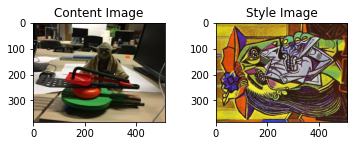

In [4]:
# set up content and style inputs
content_path = "content/objects.JPG"
style_path = "styles/picasso.jpg"

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(2, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(2, 2, 2)
imshow(style_image, 'Style Image')

In [5]:
# set up keras model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')  # without classification head

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model


style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
# define model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


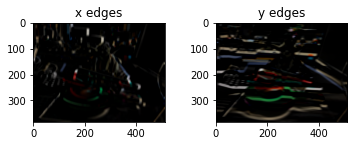

In [13]:
# define loss function and training step

def style_content_loss(outputs):
    '''calculates loss based on content and style targets'''
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


def sobel_filter(image):
    '''run sobel_edges and separate into x and y images'''
    edges = tf.image.sobel_edges(content_image)
    edge_imgs = tf.unstack(edges, axis=-1)
    edge_y = tf.squeeze(edge_imgs[0], axis=0)
    edge_x = tf.squeeze(edge_imgs[1], axis=0)

    # mean filter to capture edge density of image regions
    filter_shape = (10,10)
    edge_x = mean_filter2d(edge_x, filter_shape)
    edge_y = mean_filter2d(edge_y, filter_shape)

    return edge_x, edge_y


# Sobel responses of original content image (edge target)
sobel_x0, sobel_y0 = sobel_filter(content_image)
plt.subplot(2, 2, 1)
imshow(sobel_x0, 'x edges')
plt.subplot(2, 2, 2)
imshow(sobel_y0, 'y edges')


def edge_loss(image):
    '''calculate loss term for edge similarity to content input'''
    sobel_x, sobel_y = sobel_filter(image)
    loss_x = tf.add_n([tf.reduce_mean((sobel_x - sobel_x0)**2)])
    loss_y = tf.add_n([tf.reduce_mean((sobel_y - sobel_y0)**2)])
    return (loss_x + loss_y)/2.


@tf.function()  # Compiles a function into a callable TensorFlow graph
def train_step(image):
    '''defines one step updating the image'''
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs) + edge_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

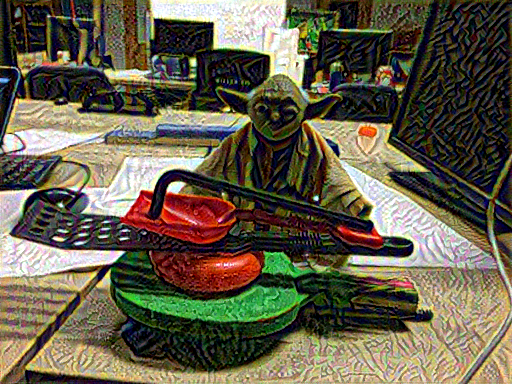

Train step: 20
Total time: 118.9


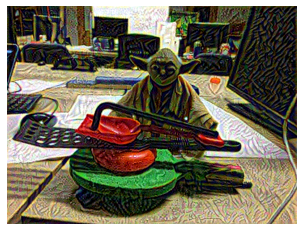

In [14]:
# run neural style transfer

extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-2
content_weight = 1e4

start = time.time()

epochs = 5
steps_per_epoch = 100
# epochs = 2
# steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    img = tensor_to_image(image)
    display.display(img)
    print("Train step: {}".format(step))
    
    plt.imshow(img)
    plt.axis('off')
    filename = "output_{}.png".format(n)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, frameon='false')

end = time.time()
print("Total time: {:.1f}".format(end - start))